# Lab 5.1 – Skin cancer segmentaion: UNet (MONAI)

This notebook implements training of a 2D **UNet** from MONAI library (https://monai-dev.readthedocs.io/en/fixes-sphinx/_modules/monai/networks/nets/unet.html#UNet) to segment skin cancer. The training code is also customizable to enable training with a different target. In this notebook, we are using the **HAM10000 Dataset** (https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification?select=masks)

This example code will consist of:

1. **Setup**
2. **Load Data & Set Transforms**
3. **Define Model & Set Hyper Parameter**
4. **Train Model**
5. **Inference & Evaluate & Save**



## 1) Setup
The code below download dataset, imports all required libraries and defines utility functions that will be used in the rest of this notebook.

In [1]:
# Download Dataset
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_segment.zip
!unzip -q -o 'Ham10000_segment.zip'

# Pip libraries
!pip install monai
!pip install pytorch-ignite

--2026-01-10 18:14:18--  https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_segment.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_segment.zip [following]
--2026-01-10 18:14:18--  https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_segment.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55191004 (53M) [application/zip]
Saving to: ‘Ham10000_segment.zip.1’

Ham10000_segment.zi 100%[===================>]  52.63M  50.8MB/s    in 1.0s    

2026-01-10 18:14:

In [2]:
# Import library
import os
import matplotlib.pyplot as plt
import random
import monai
from monai.data import Dataset, CacheDataset, DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    AsDiscreted,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandFlipd,
    Resized,
    ScaleIntensityRanged,
    Invertd,
    SaveImage,
)
from monai.utils import first, set_determinism
import numpy as np
from tqdm import tqdm
import glob
import torch
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


In [ ]:
def set_seed(seed: int = 42):
    # Python random
    random.seed(seed)
    # NumPy
    np.random.seed(seed)
    # PyTorch CPU
    torch.manual_seed(seed)
    # PyTorch GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2026)

## 2) Load Data & Set Transforms

This section of the code is mainly responsible for preparing the data for training a deep learning model. It consists of three key parts:
1. splitting the dataset into training, validation, and test sets
2. Transforms are functions that manipulate data to make it suitable for model training
3. The DataLoader systematically feeds data into the model by handling batch, shuffle, and parallel loading.

This section of code utilizes Monai functions, including:

`Transforms` which comprises components designed specifically for medical image.

`CacheDataset` and `DataLoader` designed to accelerate training by preloading and caching data in memory after deterministic transforms have been applied, offering greater speed than PyTorch.

In [47]:
# Dataset
train_images = sorted(glob.glob(os.path.join("/content/images", "*.jpg")))
train_labels = sorted(glob.glob(os.path.join("/content/masks", "*.png")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files, test_files = data_dicts[40:80] + data_dicts[120:], data_dicts[80:120], data_dicts[:40]

In [48]:
# Transforms (pre&post proceeding)
roi_size = (128, 128)
train_transforms = Compose(
        [ # 1) Load data path -> tensor
          LoadImaged(keys=["image", "label"],ensure_channel_first=True,image_only=True,dtype=torch.float),
          # 2) scale intensity [0-255] -> [0-1]
          ScaleIntensityRanged(keys=["image", "label"], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
          # 3) Resize tensor [HxW] -> [128x128]
          Resized(keys=["image", "label"], spatial_size=roi_size, mode=["bilinear", "nearest-exact"]),
          # 4) Augment (Random flip in each epoch.)
          RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        ]
    )
val_transforms = Compose(
        [
          # 1) Load data path -> tensor
          LoadImaged(keys=["image", "label"],ensure_channel_first=True,image_only=True,dtype=torch.float),
          # 2) scale intensity [0-255] -> [0-1]
          ScaleIntensityRanged(keys=["image", "label"], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
          # 3) Resize tensor [HxW] -> [128x128]
          Resized(keys=["image", "label"], spatial_size=roi_size, mode=["bilinear", "nearest-exact"]),
        ]
    )

test_transforms = Compose(
        [
          # 1) Load data path -> tensor
          LoadImaged(keys=["image", "label"],ensure_channel_first=True,image_only=True,dtype=torch.float),
          # 2) scale intensity [0-255] -> [0-1]
          ScaleIntensityRanged(keys=["image", "label"], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
          # 3) Resize tensor [HxW] -> [128x128]
          Resized(keys=["image", "label"], spatial_size=roi_size, mode=["bilinear", "nearest-exact"]),
        ]
    )

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)]) # argmax
post_label = Compose([AsDiscrete(to_onehot=2)])             # argmax

In [49]:
# Dataset
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=20)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=20)
#Use 20 processes to prepare the data and 100% of the dataset is cached.

Loading dataset: 100%|██████████| 40/40 [00:00<00:00, 44.89it/s]


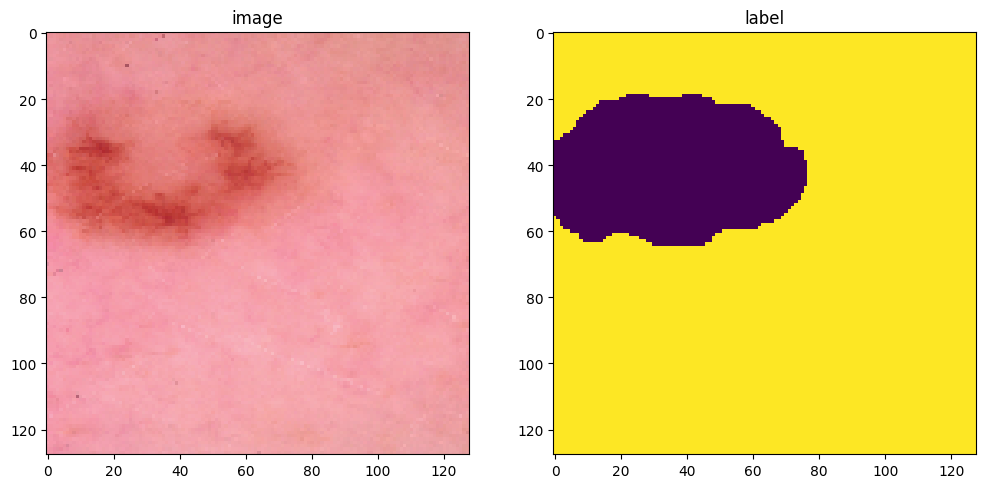

In [50]:
image = train_ds[0]["image"].permute(1, 2, 0).cpu().numpy()
label = train_ds[0]["label"][0].cpu().numpy()

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :])
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :])
plt.show()

In [51]:
# DataLoader
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=20)
val_loader = DataLoader(val_ds, batch_size=4, num_workers=20)

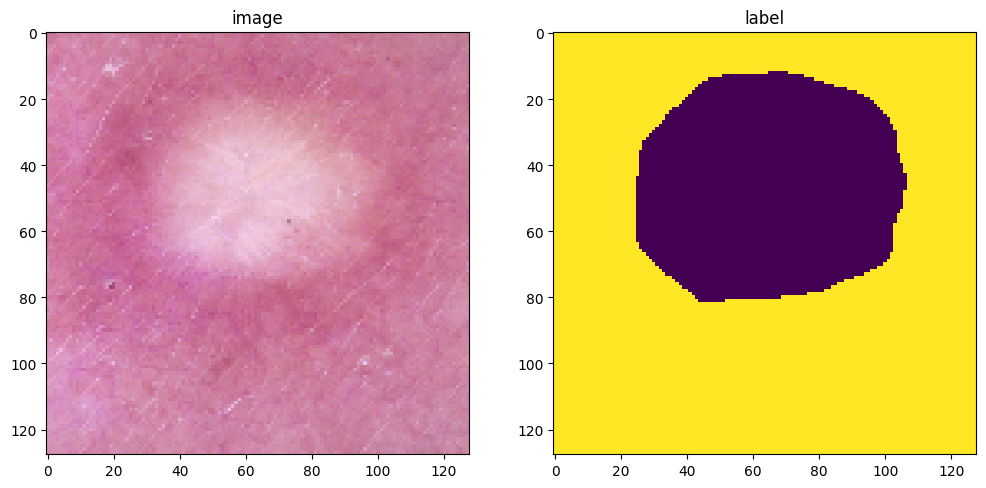

In [52]:
# Example image
check_all_ds = Dataset(data=val_files, transform=val_transforms)
check_all_loader = DataLoader(check_all_ds, batch_size=1)

check_data = first(check_all_loader)
image, label = (check_data["image"][0], check_data["label"][0])
image = image.permute(1, 2, 0).cpu().numpy()

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :])
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0][:, :])
plt.show()

## 3) Define Model & Set Hyper Parameter

This part defines the deep learning model settings, including the learning rate, loss function, optimizer, and other hyperparameters used for training.

We use the UNet model and `DiceCELoss`, which are built-in deep learning models and loss functions in MONAI. Because MONAI is a PyTorch-based framework, it is also compatible with pyTorch function, such as `optim.Adam.`

Choose hyper parameter

`max_epochs`: number of iterations to training.

`val_interval`: The number of iterations per cycle will be evaluate on the validation dataset.

`learning_rate`: the learning rate for gradient based updates.
This also starts the training!

Important: If you're on google colab the checkpoint will not be saved permanently. To save it you will need to copy the local folder checkpoints to your google drive.


In [56]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = UNet(spatial_dims=2, in_channels=3, out_channels=2,
             channels=(16, 32, 64, 128), strides=(2, 2, 2)).to(device)

learning_rate = 0.0001 # @param {type:"slider", min:1e-4, max:1e-3, step:1e-4}
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
dice_metric = DiceMetric(include_background=False, reduction="mean")

max_epochs = 50  # @param {type:"slider", min:5, max:100, step:1}
val_interval = 2 # @param {type:"slider", min:1, max:10, step:1}

## 4) Train Model

In [57]:
# This cell will take approximately 5-10 minutes to process.
# Execute a typical PyTorch training process
best_metric = -1
best_metric_epoch = -1
epoch_loss_values_train = []
epoch_loss_values_val = []
metric_values_train = []
metric_values_val = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    model.eval()
    epoch_loss = 0
    step = 0
    with torch.no_grad():
      for i, batch_data in enumerate(val_loader):
          step += 1
          inputs, labels = (batch_data["image"].to(device), batch_data["label"].to(device))
          outputs = model(inputs)
          loss = loss_function(outputs, labels)
          epoch_loss += loss.item()
    epoch_loss /= step
    epoch_loss_values_val.append(epoch_loss)

    model.train()

    epoch_loss = 0
    step = 0
    for i, batch_data in enumerate(train_loader):
        step += 1
        inputs, labels = (batch_data["image"].to(device), batch_data["label"].to(device))

        optimizer.zero_grad()
        outputs = model(inputs)                 # predict outputs
        loss = loss_function(outputs, labels)   # calculate loss
        loss.backward()                         # backpropagation
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        if step % 10 == 0:
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values_train.append(epoch_loss)

    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                sw_batch_size = 1
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values_val.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join("UNet_best_metric_model.pth"), _use_new_zipfile_serialization=False) #####
                print("saved new best metric model")
            print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

        with torch.no_grad():
            for train_data in train_loader:
                train_inputs, train_labels = (
                        train_data["image"].to(device),
                        train_data["label"].to(device),
                    )
                sw_batch_size = 1
                train_outputs = sliding_window_inference(train_inputs, roi_size, sw_batch_size, model)
                train_outputs = [post_pred(i) for i in decollate_batch(train_outputs)]
                train_labels = [post_label(i) for i in decollate_batch(train_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=train_outputs, y=train_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values_train.append(metric)

----------
epoch 1/50
10/30, train_loss: 1.0785
20/30, train_loss: 0.8655
30/30, train_loss: 0.9346
epoch 1 average loss: 1.0494
----------
epoch 2/50
10/30, train_loss: 0.8796
20/30, train_loss: 0.6563
30/30, train_loss: 0.8224
epoch 2 average loss: 0.8597
saved new best metric model
current epoch: 2 current mean dice: 0.8658
best mean dice: 0.8658 at epoch: 2
----------
epoch 3/50
10/30, train_loss: 0.7906
20/30, train_loss: 0.5433
30/30, train_loss: 0.7679
epoch 3 average loss: 0.7724
----------
epoch 4/50
10/30, train_loss: 0.7394
20/30, train_loss: 0.4853
30/30, train_loss: 0.7336
epoch 4 average loss: 0.7235
saved new best metric model
current epoch: 4 current mean dice: 0.8766
best mean dice: 0.8766 at epoch: 4
----------
epoch 5/50
10/30, train_loss: 0.7041
20/30, train_loss: 0.4509
30/30, train_loss: 0.7083
epoch 5 average loss: 0.6889
----------
epoch 6/50
10/30, train_loss: 0.6758
20/30, train_loss: 0.4277
30/30, train_loss: 0.6885
epoch 6 average loss: 0.6609
saved new best

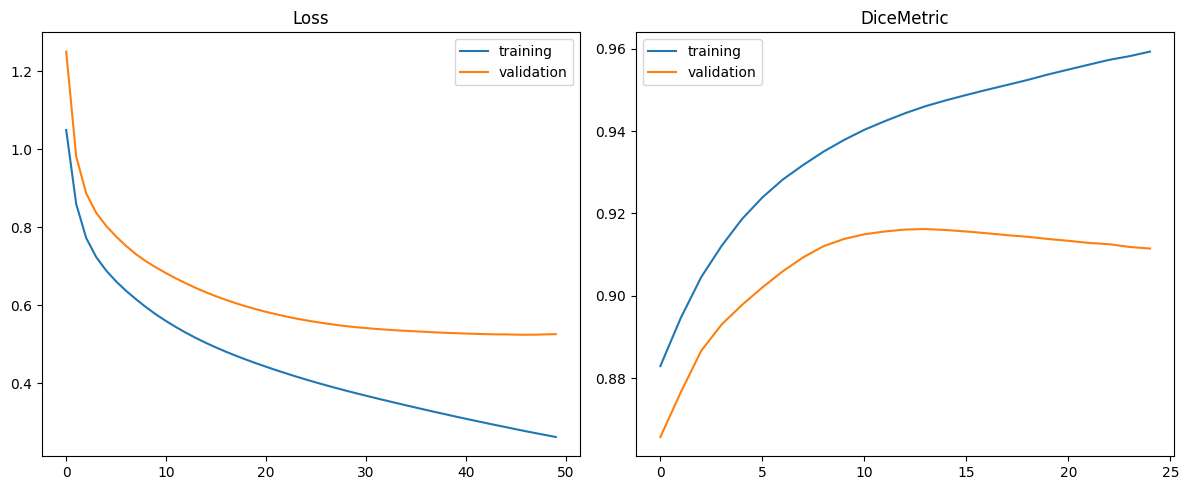

In [58]:
# Plot loss & accuracy
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# loss
axs[0].plot(epoch_loss_values_train, label='training')
axs[0].plot(epoch_loss_values_val, label='validation')
axs[0].set_title("Loss")
axs[0].legend()
# acc
axs[1].plot(metric_values_train, label='training')
axs[1].plot(metric_values_val, label='validation')
axs[1].set_title("DiceMetric")
axs[1].legend()

plt.tight_layout()
plt.show()

## 5) Inference & Evaluate & Save

This code evaluates the trained model on the test dataset and saves the output predictions in the original image size as .png files.

In [59]:
def visualize_rgb_with_dice(image, gt, pred, dice_value):
    """
    image: [3, H, W]
    gt:    [1, H, W]
    pred:  [1, H, W]
    dice_value: float
    """
    image = image.permute(1, 2, 0).cpu().numpy()
    gt = gt.squeeze().cpu().numpy()
    pred = pred.squeeze().cpu().numpy()

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title("Input (RGB)")

    axes[1].imshow(image)
    axes[1].imshow(gt, alpha=0.4, cmap="Greens")
    axes[1].set_title("GT")

    axes[2].imshow(image)
    axes[2].imshow(pred, alpha=0.4, cmap="Reds")
    axes[2].set_title(f"Prediction\nDice = {dice_value:.4f}")

    axes[3].imshow(gt)
    axes[3].imshow(pred, alpha=0.4, cmap="Reds")
    axes[3].set_title(f"GT VS Prediction\nDice = {dice_value:.4f}")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [60]:
# post_transforms is used to revert the output to its original size before test_transforms
test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=20)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=20)

post_transforms = Compose(
        [
            Invertd(
                keys="pred",
                transform=test_transforms,
                orig_keys="image",
                meta_keys="pred_meta_dict",
                orig_meta_keys="image_meta_dict",
                meta_key_postfix="meta_dict",
                nearest_interp=False,
                to_tensor=True,
            ),
            AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        ]
    )

Loading dataset: 100%|██████████| 40/40 [00:01<00:00, 27.23it/s]


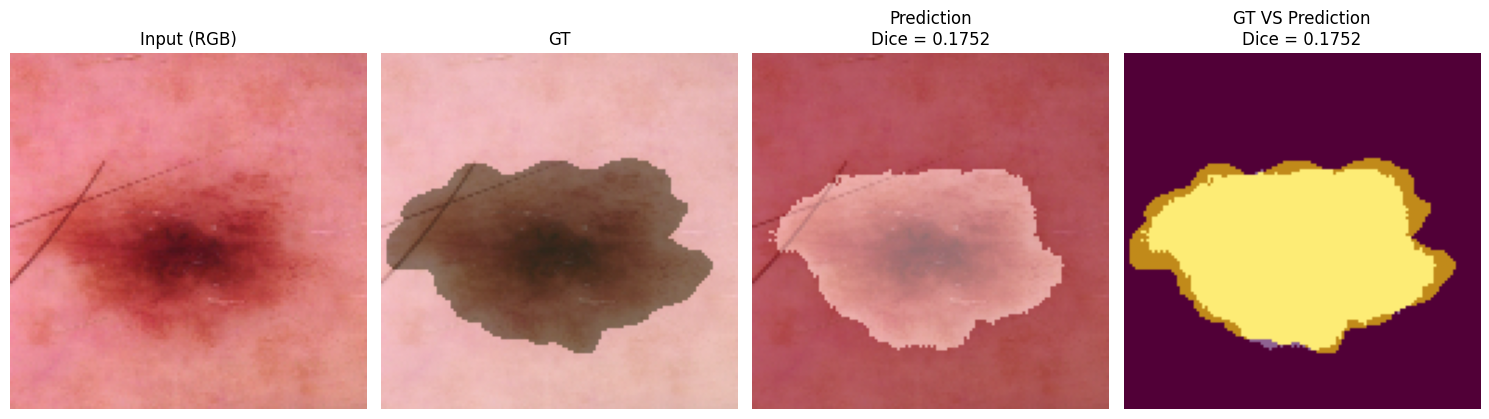

2026-01-10 19:01:07,192 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024306/ISIC_0024306__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:07,410 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024307/ISIC_0024307__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:07,772 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024308/ISIC_0024308__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:08,115 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024309/ISIC_0024309__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:08,396 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024310/ISIC_0024310__UNet.png
NIfTI file saved in output/UNet


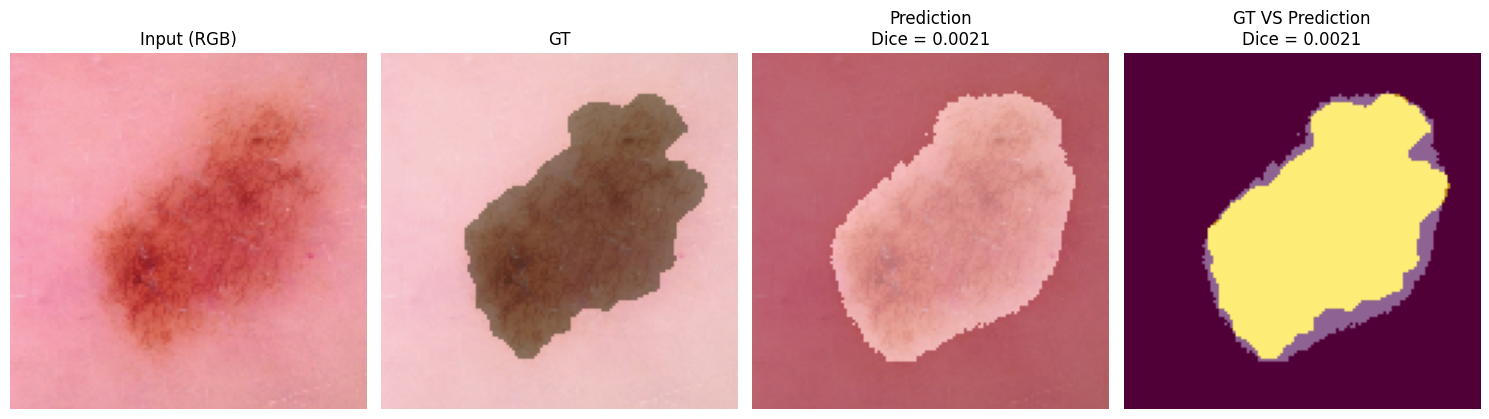

2026-01-10 19:01:09,545 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024311/ISIC_0024311__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:09,708 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024312/ISIC_0024312__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:09,829 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024313/ISIC_0024313__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:09,960 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024314/ISIC_0024314__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:10,117 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024315/ISIC_0024315__UNet.png
NIfTI file saved in output/UNet


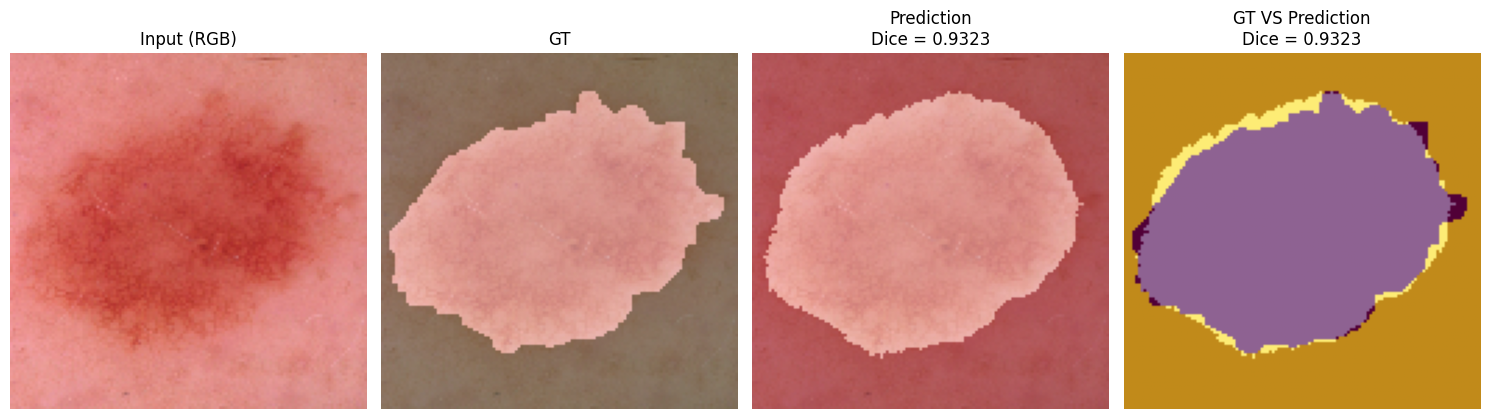

2026-01-10 19:01:11,087 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024316/ISIC_0024316__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:11,376 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024317/ISIC_0024317__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:11,529 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024318/ISIC_0024318__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:11,702 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024319/ISIC_0024319__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:11,861 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024320/ISIC_0024320__UNet.png
NIfTI file saved in output/UNet


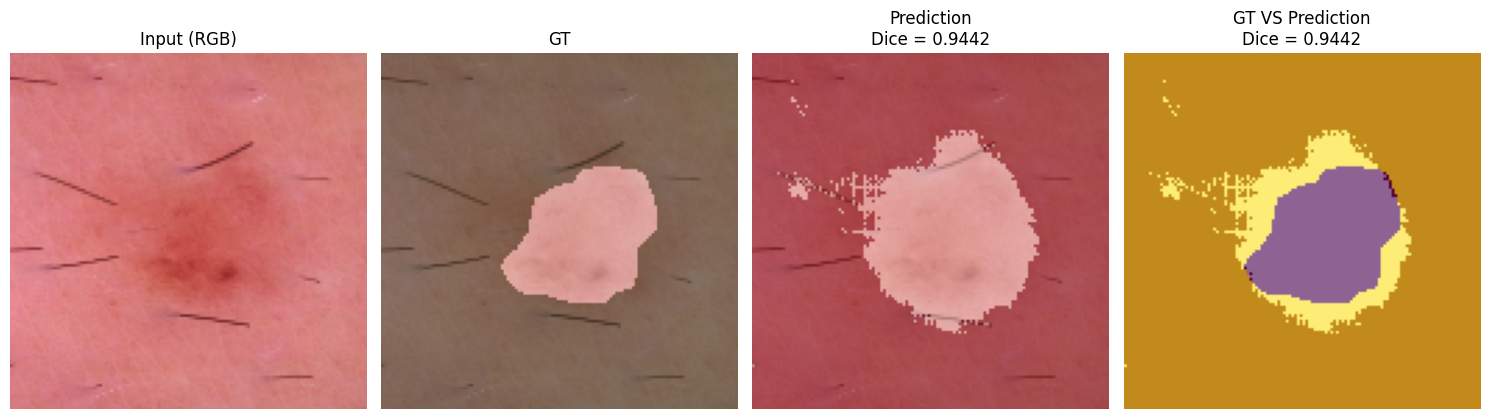

2026-01-10 19:01:12,819 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024321/ISIC_0024321__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:13,025 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024322/ISIC_0024322__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:13,206 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024323/ISIC_0024323__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:13,368 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024324/ISIC_0024324__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:13,548 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024325/ISIC_0024325__UNet.png
NIfTI file saved in output/UNet


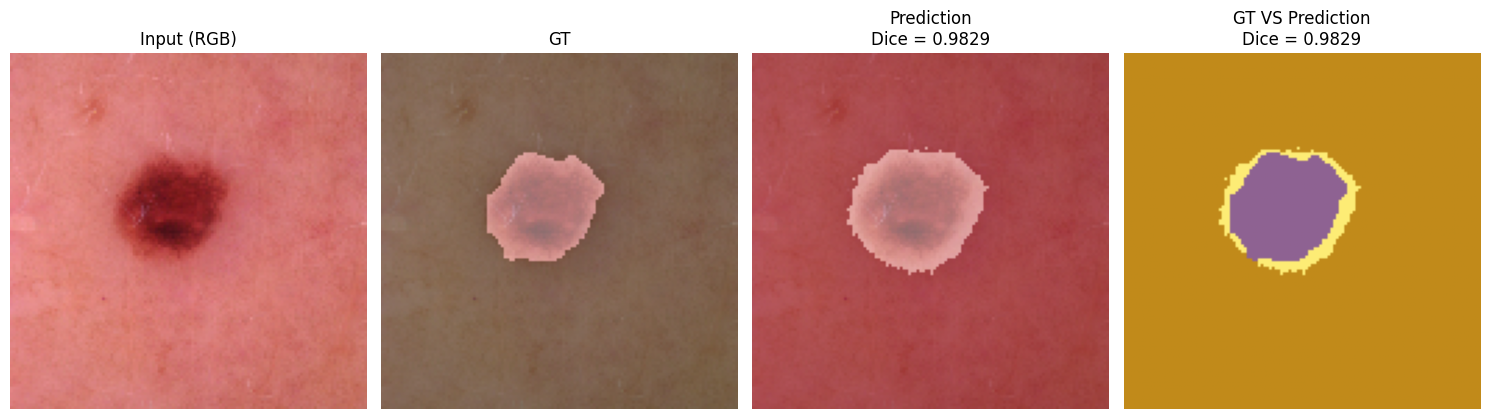

2026-01-10 19:01:14,492 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024326/ISIC_0024326__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:14,725 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024327/ISIC_0024327__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:14,909 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024328/ISIC_0024328__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:15,083 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024329/ISIC_0024329__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:15,246 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024330/ISIC_0024330__UNet.png
NIfTI file saved in output/UNet


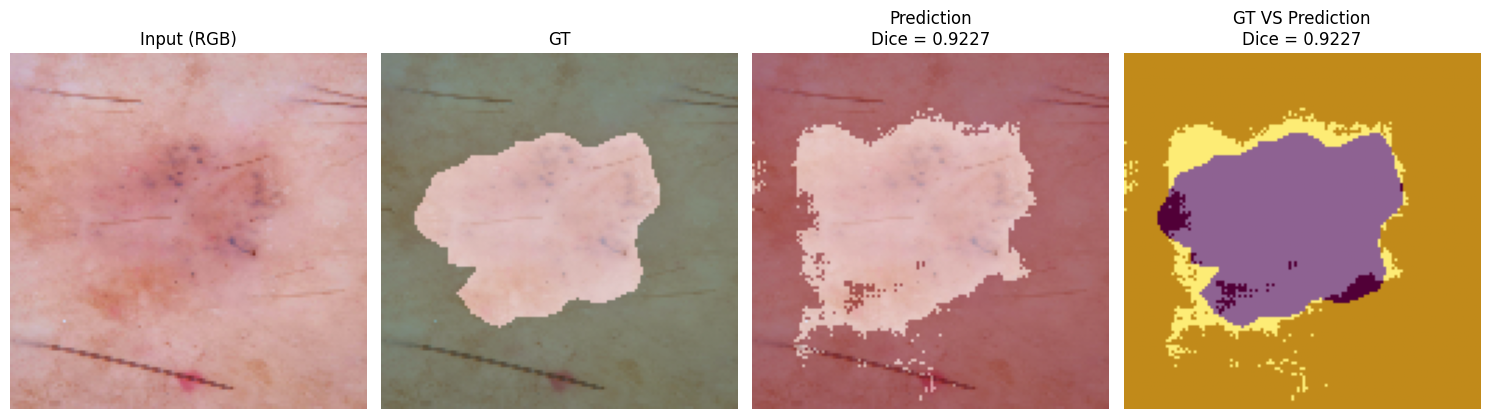

2026-01-10 19:01:16,181 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024331/ISIC_0024331__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:16,424 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024332/ISIC_0024332__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:16,622 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024333/ISIC_0024333__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:16,800 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024334/ISIC_0024334__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:16,959 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024335/ISIC_0024335__UNet.png
NIfTI file saved in output/UNet


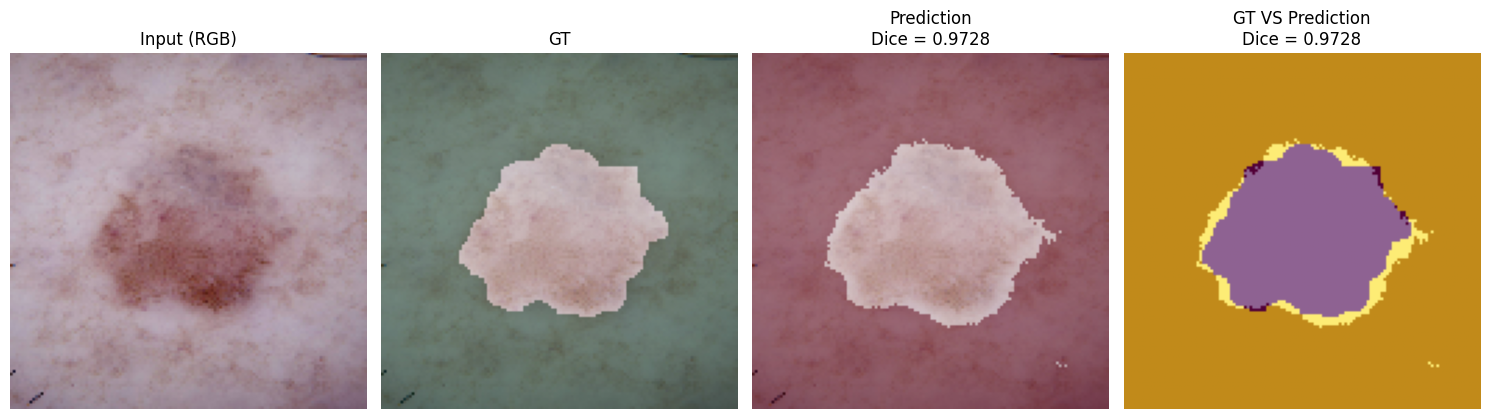

2026-01-10 19:01:17,946 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024336/ISIC_0024336__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:18,174 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024337/ISIC_0024337__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:18,393 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024338/ISIC_0024338__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:18,611 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024339/ISIC_0024339__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:18,795 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024340/ISIC_0024340__UNet.png
NIfTI file saved in output/UNet


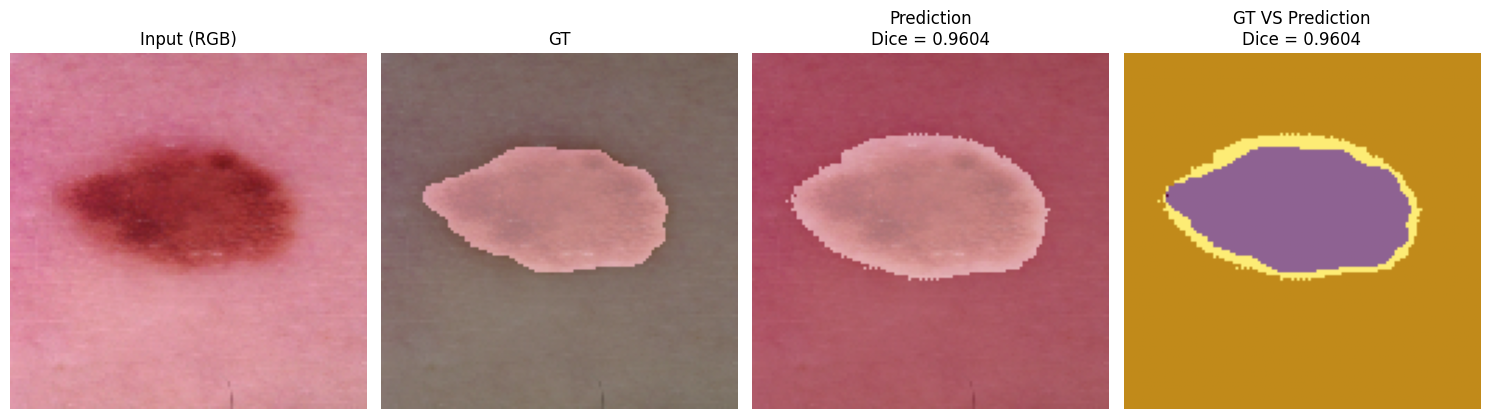

2026-01-10 19:01:20,120 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024341/ISIC_0024341__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:20,412 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024342/ISIC_0024342__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:20,694 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024343/ISIC_0024343__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:20,971 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024344/ISIC_0024344__UNet.png
NIfTI file saved in output/UNet
2026-01-10 19:01:21,230 INFO image_writer.py:197 - writing: output/UNet/ISIC_0024345/ISIC_0024345__UNet.png
NIfTI file saved in output/UNet

Mean Dice: 0.7297


In [61]:
# Example & Save (.png)
# Load best model
model.load_state_dict(torch.load(os.path.join("/content/UNet_best_metric_model.pth")))
model.eval()

DSC_all = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        img = batch["image"].to(device)
        label = batch["label"].to(device)

        output = model(img)
        pred = torch.argmax(output, dim=1, keepdim=True)

        dice_metric = DiceMetric(include_background=False, reduction="mean")

        dice_metric(y_pred=pred[0], y=label[0].to(device))
        DSC_all.append(dice_metric.aggregate().item())

        if i % 5 == 0:
            visualize_rgb_with_dice(
                image=img[0],
                gt=label[0],
                pred=pred[0],
                dice_value=dice_metric.aggregate().item()
            )
        dice_metric.reset()

        batch["pred"] = pred
        batch = [post_transforms(i) for i in decollate_batch(batch)]

        # Create the output directory if it doesn't exist
        output_dir = "output/UNet"                                                                                                          #####
        os.makedirs(output_dir, exist_ok=True)

        # Create a tensor (e.g., a simple example tensor)
        tensor = torch.argmax(batch[0]["pred"], dim=0).detach().cpu()

        # Metadata for saving the NIfTI file
        metadata = {
                  "filename_or_obj": os.path.join(output_dir, "example.nii.gz")
                  }

        # Initialize the SaveImage transform
        saver = SaveImage(output_dir=output_dir, output_postfix="_UNet", output_ext=".png", resample=False)                                  #####

        # Save the tensor as a NIfTI file
        saver(tensor, meta_data=metadata)

        print(f"NIfTI file saved in {output_dir}")

print(f"\nMean Dice: {np.mean(DSC_all):.4f}")